In [2]:
its_jupyter_notebook = True

In [3]:
import pandas as pd
import os
import time
import numpy as np
import seaborn as sns
import pickle
import torch
from pathlib import Path
import argparse
import math
import matplotlib.pyplot as plt
import sys
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, auc

sys.path.insert(0, '..')

from util.xai import gradcam, interpolate_expl_matrix, plot_matrix
from models.nt_classifier import build as build_model
from config import *
from util.plot_utils import balance_df, obtain_plot, plot_logs, plot_roc_curves, collect_results_based_on_confidence_level
if its_jupyter_notebook:
    sys.argv = [''] #Remove this if it's not a jupyter notebook!

<class 'transformers.tokenization_dna.DNATokenizer'>


In [7]:
RANDOM = False
HOW = 'test'
SPECIE = 'human'


assert HOW in ['val', 'test']

assert SPECIE in ['human', 'mouse']


if RANDOM:
    suffix = "RANDOM"
else:
    suffix = ""

In [4]:
checkpoint_dir = os.path.join(ROOT_DIR, 'checkpoints', 'binary_cl2_12e34') 
# binary_cl2_12e34. binary_cl2_RANDOM_FINETUNED, binary_cl2_1BEST_RANDOM, 'binary_cl2_1e36_RANDOM'

In [5]:
# Define the path to the file containing the args namespace
args_path = os.path.join(checkpoint_dir, 'args.pkl')

# Load the args namespace from the file
with open(args_path, 'rb') as f:
    args_dict = pickle.load(f)
    
#print(args_dict)
#args_dict['policies_train'][0].height_probabilities
#args_dict['policies_train'][0].height_bins

In [8]:
file_train = os.path.join(rna_rna_files_dir, f"{suffix}", "gene_pairs_training.txt")
with open(file_train, "rb") as fp:   # Unpickling
    gene_pairs_train_original = pickle.load(fp)

file_train = os.path.join(rna_rna_files_dir, f"{suffix}", "gene_pairs_training_nt.txt")
with open(file_train, "rb") as fp:   # Unpickling
    gene_pairs_train = pickle.load(fp)
    
file_test = os.path.join(rna_rna_files_dir, f"{suffix}", f"gene_pairs_{HOW}_nt.txt")
with open(file_test, "rb") as fp:   # Unpickling
    gene_pairs_test = pickle.load(fp)
    
file_test_subset = os.path.join(rna_rna_files_dir, f"{suffix}", f"gene_pairs_{HOW}_sampled_nt.txt")
with open(file_test_subset, "rb") as fp:   # Unpickling
    gene_pairs_test_subset = pickle.load(fp)

In [9]:
test500 = pd.read_csv(os.path.join(metadata_dir, f'{suffix}', f'{HOW}500.csv'))
assert test500.couples.isin(gene_pairs_test).all()

In [10]:
# collect simple_repeats_id, sine_alu_id, low_complex_id info 

repeats_info = pd.read_csv(os.path.join(original_files_dir, f'index_repeats.Tx.RI_ALL.txt'), sep = '\t')[['name_1', 'Simple_repeat_unknown', 'SINE_Alu', 'Low_complexity_unknown']]

def check_for_R(value):
    return 'R' in value

repeats_info['Simple_repeat_unknown'] = repeats_info['Simple_repeat_unknown'].apply(check_for_R)
simple_repeats = set(repeats_info[repeats_info.Simple_repeat_unknown].name_1)
    
repeats_info['SINE_Alu'] = repeats_info['SINE_Alu'].apply(check_for_R)
sine_alu = set(repeats_info[repeats_info.SINE_Alu].name_1)

repeats_info['Low_complexity_unknown'] = repeats_info['Low_complexity_unknown'].apply(check_for_R)
low_complex = set(repeats_info[repeats_info.Low_complexity_unknown].name_1)

import dataset.preprocessing as utils
info = utils.read_dataframe(os.path.join(original_files_dir, 'index_bio_regions.Tx.RI_ALL.txt'), columns_to_drop = ['Unnamed: 0'])
info = info[['name','ensembl_gene_id_1', 'ensembl_gene_id_2', 'start_1', 'end_1', 'start_2', 'end_2']]
info = info.rename({'ensembl_gene_id_1':'gene_id1', 'ensembl_gene_id_2':'gene_id2', 'start_1': 'x1','end_1': 'x2','start_2': 'y1','end_2': 'y2'}, axis = 1)
info[['couples', 'need_to_swap']] = info[['gene_id1', 'gene_id2']].apply(utils.create_pairs, axis = 1)
def swap_genes_if_needed(df):
    original_dim = df.shape[0]
    where = df.need_to_swap
    df.loc[where, ['gene_id1', 'gene_id2']] = (df.loc[where, ['gene_id2', 'gene_id1']].values)
    df.loc[where, ['x1', 'y1']] = (df.loc[where, ['y1', 'x1']].values)
    df.loc[where, ['x2', 'y2']] = (df.loc[where, ['y2', 'x2']].values)
    df = df.drop('need_to_swap', axis = 1)
    df = df.drop_duplicates().reset_index(drop = True)
    n_duplicates = original_dim - df.shape[0] 
    print(f"{n_duplicates} interactions were duplicated (the genes were swopped, now they have a unique couples_id so I can see only now that they are duplicated)")
    return df
info = swap_genes_if_needed(info)

simple_repeats = info[info.name.isin(simple_repeats)]
sine_alu = info[info.name.isin(sine_alu)]
low_complex = info[info.name.isin(low_complex)]

hq_test = test500.copy()
regex1 = hq_test.gene1.str.extractall('(.*)_(.*)_(.*)').reset_index()
regex2 = hq_test.gene2.str.extractall('(.*)_(.*)_(.*)').reset_index()
hq_test['g1g2_id'] = regex1[0] + '_' + regex2[0]
hq_test['x1_window'] = regex1[1]
hq_test['y1_window'] = regex2[1]
hq_test[['x1_window', 'y1_window']] = hq_test[['x1_window', 'y1_window']].apply(pd.to_numeric)

hq_test['real_seed_x1'] = hq_test['x1_window'] + hq_test['seed_x1']
hq_test['real_seed_x2'] = hq_test['x1_window'] + hq_test['seed_x2']
hq_test['real_seed_y1'] = hq_test['y1_window'] + hq_test['seed_y1']
hq_test['real_seed_y2'] = hq_test['y1_window'] + hq_test['seed_y2']

hq_test = hq_test[['couples', 'g1g2_id', 'real_seed_x1', 'real_seed_x2', 'real_seed_y1', 'real_seed_y2']].rename(
    {'couples':'real_id_couple', 'g1g2_id': 'couples', 'real_seed_x1':'x1', 'real_seed_x2':'x2', 
     'real_seed_y1':'y1', 'real_seed_y2':'y2'}, axis = 1)

simple_repeats_id = set(hq_test.merge(simple_repeats, on = ['couples', 'x1', 'x2', 'y1', 'y2']).real_id_couple)
sine_alu_id = set(hq_test.merge(sine_alu, on = ['couples', 'x1', 'x2', 'y1', 'y2']).real_id_couple)
low_complex_id = set(hq_test.merge(low_complex, on = ['couples', 'x1', 'x2', 'y1', 'y2']).real_id_couple)

/data01/giorgio/ENTER/envs/dnabert/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (2,4,6,8,22,26,36,37,42,44,45,46,56,57,58,59,60,61,62) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


0 interactions were duplicated (the genes were swopped, now they have a unique couples_id so I can see only now that they are duplicated)


In [11]:
res = pd.read_csv(os.path.join(checkpoint_dir, f'{HOW}_results500.csv'))

# Drop all the pairs (they should be 60-70) that are present in the training set.
res = res[~res.couples.isin(gene_pairs_train_original)]

# show only results for 1 specie
res = res[res.specie == SPECIE]

print(classification_report(res.ground_truth, res.prediction))

              precision    recall  f1-score   support

           0       0.74      0.61      0.67     21111
           1       0.39      0.54      0.45      9884

    accuracy                           0.59     30995
   macro avg       0.57      0.57      0.56     30995
weighted avg       0.63      0.59      0.60     30995



In [12]:
intarna = pd.read_csv(os.path.join(intarna_dir, f'{suffix}', f'{HOW}500', f'{HOW}.csv'), sep = ';')
intarna['key'] = intarna.id1 + '_' + intarna.id2

# keep only the lower E_norm for each group
intarna.sort_values('E_norm', ascending = False, inplace=True)
intarna.drop_duplicates(subset='key', keep='first', inplace=True)
intarna = intarna.reset_index(drop = True)
intarna['couples'] = intarna.id1.str.extractall('(.*)_(.*)').reset_index(drop = True)[0]
intarna['couples'] = intarna['couples'].astype(int)

# #merge with id of df_nt
# df_nt = pd.read_csv(os.path.join(metadata_dir, f'df_nt.csv'))
# df_nt = df_nt[['couples', 'interacting']]
# df_nt['interacting'] = df_nt['interacting'].astype(int)

intarna = intarna.dropna()

res = res.merge(intarna[['E','E_norm', 'couples']].rename({'couples':'id_sample'}, axis =1), on = 'id_sample')

# PLOTS

### Log plots

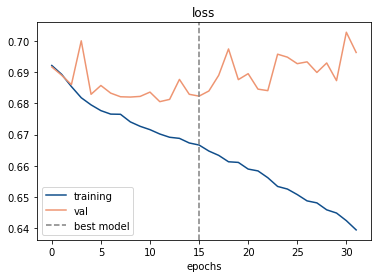

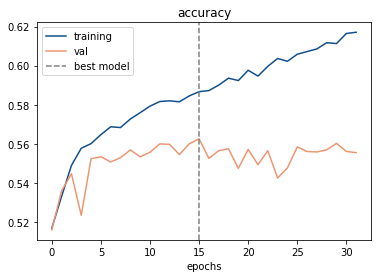

In [13]:
log = pd.read_json(Path(os.path.join(checkpoint_dir, 'log.txt')), lines=True)
best_model = log.iloc[np.argmax(log.test_accuracy)].epoch
for metric in ['loss', 'accuracy']:
    plot_logs(log, metric, best_model = best_model)

## Metrics

In [14]:
print(res.prediction.value_counts())
print('\n')
print(res.ground_truth.value_counts())

0    17534
1    13461
Name: prediction, dtype: int64


0    21111
1     9884
Name: ground_truth, dtype: int64


In [15]:
n_conf = 10

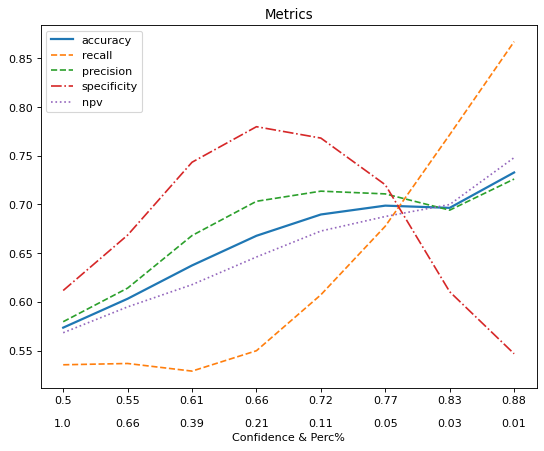

In [16]:
obtain_plot(balance_df(res), n_original_df = res.shape[0], title = 'Metrics', n_conf = n_conf)

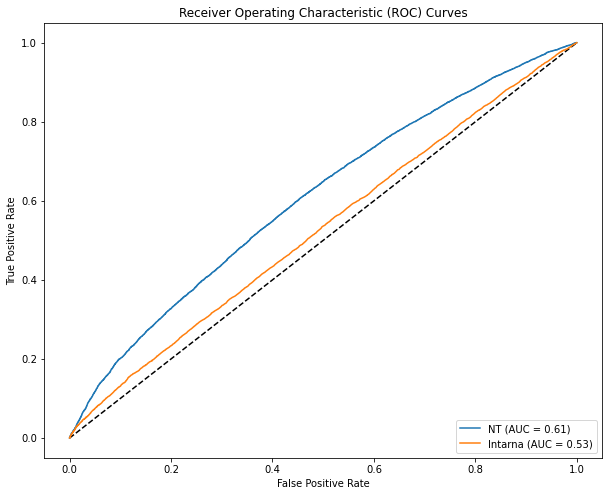

In [17]:
plot_roc_curves([{'prob': res.probability, 'model_name': 'NT'},
                 {'prob': abs(res.E_norm), 'model_name': 'Intarna'}
                ], res.ground_truth)

In [18]:
# full_length = res[(res.original_length1 <= MAX_RNA_SIZE)&(res.original_length2 <= MAX_RNA_SIZE)]
# obtain_plot(balance_df(full_length), n_original_df = res.shape[0], title = f'Metrics: Full length', n_conf = 10)

# confidence_level = 0.65
# high_conf_fl = full_length[(full_length.probability>confidence_level)|(full_length.probability<(1-confidence_level))]
# obtain_plot(balance_df(high_conf_fl), n_original_df = res.shape[0], title = f'Metrics: Full length (high confidence)', n_conf = n_conf, excluding_treshold = 0.05)

In [19]:
# no_pc = res[(res['gene1_pc'] == False)|(res['gene2_pc'] == False)]

# obtain_plot(balance_df(no_pc), n_original_df = res.shape[0], title = f'Metrics: At least one is no protein coding', n_conf = n_conf)

0.5727725602286647


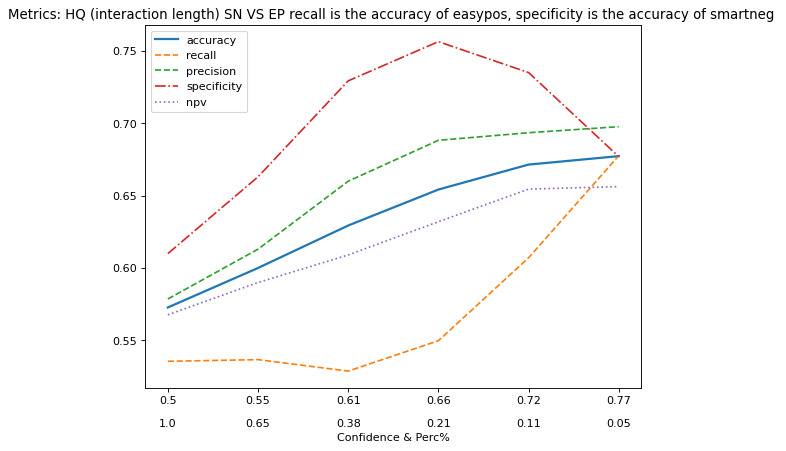

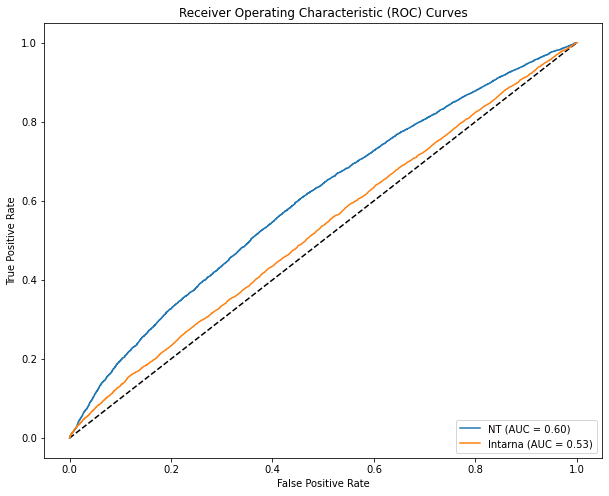

In [20]:
subset_test_nt_sampled = os.path.join(rna_rna_files_dir, f'{suffix}', f"gene_pairs_{HOW}_sampled_nt.txt")
with open(subset_test_nt_sampled, "rb") as fp:  # Unpickling
    subset_test_nt_sampled = pickle.load(fp)
    
easypos_smartneg_HQ = res[res.id_sample.isin(subset_test_nt_sampled)]

# easypos_smartneg_HQ = easypos_smartneg_HQ[easypos_smartneg_HQ.specie == 'human']
# easypos_smartneg_HQ = balance_df(easypos_smartneg_HQ)

# vc = easypos_smartneg.ground_truth.value_counts()
# assert vc.loc[1] > vc.loc[0]
# n_to_exclude = vc.loc[1] - vc.loc[0]
# easypos_gt = easypos_smartneg[easypos_smartneg.ground_truth==1]
# id_to_exclude = list(easypos_gt.sample(frac = 1).head(n_to_exclude).id_sample)
# easypos_smartneg_sampled = easypos_smartneg[~easypos_smartneg.id_sample.isin(id_to_exclude)]

easypos_smartneg_sampled = easypos_smartneg_HQ
easypos_smartneg_sampled = balance_df(easypos_smartneg_sampled)
print((easypos_smartneg_sampled.prediction == easypos_smartneg_sampled.ground_truth).sum()/easypos_smartneg_sampled.shape[0])
obtain_plot(easypos_smartneg_sampled, n_original_df = res.shape[0], title = f'Metrics: HQ (interaction length) SN VS EP recall is the accuracy of easypos, specificity is the accuracy of smartneg ', 
            n_conf = n_conf, excluding_treshold = 0.05)

plot_roc_curves([{'prob': easypos_smartneg_sampled.probability, 'model_name': 'NT'},
                 {'prob': abs(easypos_smartneg_sampled.E_norm), 'model_name': 'Intarna'}
                ], easypos_smartneg_sampled.ground_truth)

In [21]:
from scipy.stats import chi2_contingency, fisher_exact

how = 'fisher'

def calc_test(ep, list_id, how = 'chi2'):
    
    sr = ep[ep.id_sample.isin(list_id)]
    no_sr = ep[~ep.id_sample.isin(list_id)]
    
    a = sr[sr.prediction == 1].shape[0]
    b = no_sr[no_sr.prediction == 1].shape[0]
    c = sr[sr.prediction == 0].shape[0]
    d = no_sr[no_sr.prediction == 0].shape[0]
    test(a, b, c, d, how = how)

def test(a, b, c, d, how):
    # Crea una tabella di contingenza tra veri positivi e falsi negativi rispetto a SIMPLE_REPEAT
    # Ad esempio, supponiamo che tu abbia i seguenti dati:
    #           | SIMPLE_REPEAT = True  | SIMPLE_REPEAT = False
    # ----------------------------------------------
    # Veri Positivi   |       a              |       b
    # Falsi Negativi  |       c              |       d


    # Crea la tabella di contingenza
    observed = np.array([[a, b], [c, d]])
    
    if how=='chi2':
        # Esegue il test del chi-quadro per l'indipendenza
        chi2, p, _, _ = chi2_contingency(observed)

    else:
        odds_ratio, p = fisher_exact([[a, b], [c, d]])
        
    # Valuta la significatività
    alpha = 0.05
    if p < alpha:
        print(f"Il test è statisticamente significativo (p = {np.round(p, 2)}).")
        print("Ci sono evidenze di un'associazione tra Veri Positivi/Falsi Negativi e Variabile (es.Simple Repeat).")
    else:
        print(f"Il test non è statisticamente significativo (p = {np.round(p, 2)}).")

# TODO: FAI TEST DI FISHER SU QUESTI

#simple_repeats_id, sine_alu_id, low_complex_id
ep = res[(res.policy == 'easypos')]
print(f'easypos accuracy: {ep[ep.prediction == 1].shape[0]/ep.shape[0]}')

sr = ep[ep.id_sample.isin(simple_repeats_id)]
print(f'\n simple repeat accuracy: {sr[sr.prediction == 1].shape[0]/sr.shape[0]}. The # of simple repeat samples is {np.round(sr.shape[0]/ep.shape[0] * 100, 2)}% of the positives.')
calc_test(ep, simple_repeats_id, how = how)


sa = ep[ep.id_sample.isin(sine_alu_id)]
print(f'\n sine alu accuracy: {sa[sa.prediction == 1].shape[0]/sa.shape[0]}. The # of simple repeat samples is {np.round(sa.shape[0]/ep.shape[0] * 100, 2)}% of the positives.')
calc_test(ep, sine_alu_id, how = how)


lc = ep[ep.id_sample.isin(low_complex_id)]
print(f'\n low complexity accuracy: {lc[lc.prediction == 1].shape[0]/lc.shape[0]}. The # of simple repeat samples is {np.round(lc.shape[0]/ep.shape[0] * 100, 2)}% of the positives.')
calc_test(ep, low_complex_id, how = how)


print('\n ------ HQ ------ \n')

ep = easypos_smartneg_sampled[(easypos_smartneg_sampled.policy == 'easypos')]
print(f'\n easypos accuracy: {ep[ep.prediction == 1].shape[0]/ep.shape[0]}')

sr = ep[ep.id_sample.isin(simple_repeats_id)]
print(f'\n simple repeat accuracy: {sr[sr.prediction == 1].shape[0]/sr.shape[0]}. The # of simple repeat samples is {np.round(sr.shape[0]/ep.shape[0] * 100, 2)}% of the positives.')
calc_test(ep, simple_repeats_id, how = how)

sa = ep[ep.id_sample.isin(sine_alu_id)]
print(f'\n sine alu accuracy: {sa[sa.prediction == 1].shape[0]/sa.shape[0]}. The # of simple repeat samples is {np.round(sa.shape[0]/ep.shape[0] * 100, 2)}% of the positives.')
calc_test(ep, sine_alu_id, how = how)

lc = ep[ep.id_sample.isin(low_complex_id)]
print(f'\n low complexity accuracy: {lc[lc.prediction == 1].shape[0]/lc.shape[0]}. The # of simple repeat samples is {np.round(lc.shape[0]/ep.shape[0] * 100, 2)}% of the positives.')
calc_test(ep, low_complex_id, how = how)

easypos accuracy: 0.5355119384864427

 simple repeat accuracy: 0.5448877805486284. The # of simple repeat samples is 8.11% of the positives.
Il test non è statisticamente significativo (p = 0.61).

 sine alu accuracy: 0.4980217606330366. The # of simple repeat samples is 20.46% of the positives.
Il test è statisticamente significativo (p = 0.0).
Ci sono evidenze di un'associazione tra Veri Positivi/Falsi Negativi e Variabile (es.Simple Repeat).

 low complexity accuracy: 0.5274725274725275. The # of simple repeat samples is 0.92% of the positives.
Il test non è statisticamente significativo (p = 0.92).

 ------ HQ ------ 


 easypos accuracy: 0.5356022866476112

 simple repeat accuracy: 0.5450699969785477. The # of simple repeat samples is 8.11% of the positives.
Il test è statisticamente significativo (p = 0.01).
Ci sono evidenze di un'associazione tra Veri Positivi/Falsi Negativi e Variabile (es.Simple Repeat).

 sine alu accuracy: 0.49817412647416837. The # of simple repeat samples 

5.664204775394577e-01


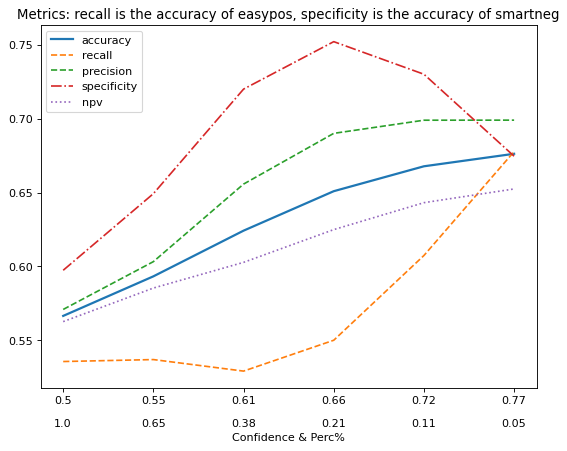

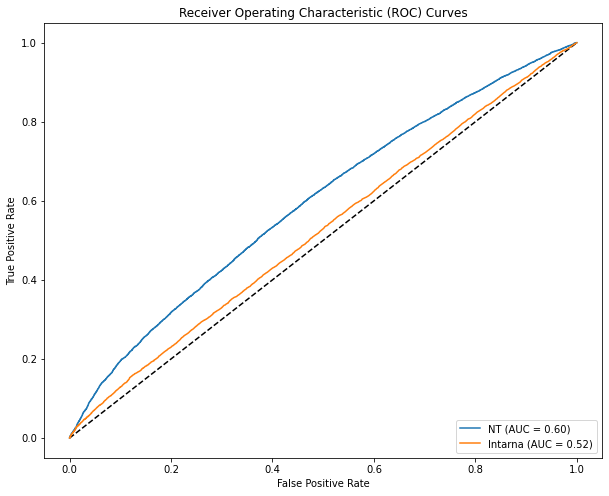

In [22]:
subset_test_nt_sampled = os.path.join(rna_rna_files_dir, f'{suffix}', f"gene_pairs_{HOW}.txt")
with open(subset_test_nt_sampled, "rb") as fp:  # Unpickling
    subset_test_nt_sampled = pickle.load(fp)
    
all_val = res[res.couples.isin(subset_test_nt_sampled)]
assert all_val.shape[0] == res.shape[0]
easypos_smartneg = all_val[all_val.policy.isin(['smartneg', 'easypos'])]

easypos_smartneg_balanced = balance_df(easypos_smartneg)

print((easypos_smartneg_balanced.prediction == easypos_smartneg_balanced.ground_truth).sum()/easypos_smartneg_balanced.shape[0])


obtain_plot(easypos_smartneg_balanced, n_original_df = res.shape[0], title = f'Metrics: recall is the accuracy of easypos, specificity is the accuracy of smartneg', 
            n_conf = n_conf, excluding_treshold = 0.05)

plot_roc_curves([{'prob': easypos_smartneg_balanced.probability, 'model_name': 'NT'},
                 {'prob': abs(easypos_smartneg_balanced.E_norm), 'model_name': 'Intarna'}
                ], easypos_smartneg_balanced.ground_truth)

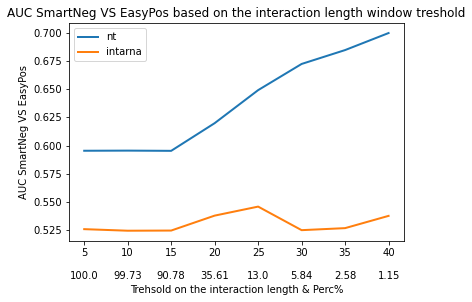

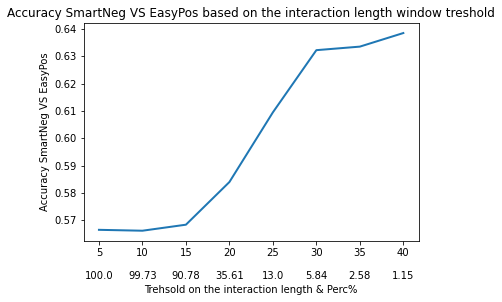

In [23]:
MIN_PERC = 1

def obtain_auc_and_perc(treshold, res, test500, balance = True, intarna = False):
    original_res_shape = res.shape[0]
    #take only big windows
    subset = test500[ (abs(test500.seed_x1 - test500.seed_x2) >treshold) & (abs(test500.seed_y1 - test500.seed_y2) > treshold) ]
    res = res[res.id_sample.isin(subset.couples)]
    
    perc = np.round((res.shape[0] / original_res_shape)*100, 2)
    
    if balance:
        res = balance_df(res)
    
    if intarna:
        fpr, tpr, _ = roc_curve(abs(1 - res.ground_truth), res.E_norm)
        roc_auc = auc(fpr, tpr)
    else:
        fpr, tpr, _ = roc_curve(res.ground_truth, res.probability)
        roc_auc = auc(fpr, tpr)
    
    return roc_auc, perc

def obtain_acc_and_perc(treshold, res, test500, balance = True):
    original_res_shape = res.shape[0]
    #take only big windows
    subset = test500[ (abs(test500.seed_x1 - test500.seed_x2) >treshold) & (abs(test500.seed_y1 - test500.seed_y2) > treshold) ]
    res = res[res.id_sample.isin(subset.couples)]
    
    perc = np.round((res.shape[0] / original_res_shape)*100, 2)
    
    if balance:
        res = balance_df(res)

    acc = (res.prediction == res.ground_truth).sum()/res.shape[0]
    return acc, perc

tresholds = np.linspace(5, 50, 10).astype(int)
accuracies = []
aucs_nt = []
aucs_intarna = []
percs = []
for treshold in tresholds:
    acc, perc = obtain_acc_and_perc(treshold, easypos_smartneg, test500)
    if perc > MIN_PERC:
        accuracies.append(acc)
        roc_auc, perc = obtain_auc_and_perc(treshold, easypos_smartneg, test500, balance = True, intarna = False)
        aucs_nt.append(roc_auc)
        roc_auc, perc = obtain_auc_and_perc(treshold, easypos_smartneg, test500, balance = True, intarna = True)
        aucs_intarna.append(roc_auc)
        percs.append(perc)

merged_x_axis = []
for i in range(0, len(percs)):
    tuple_to_print = (np.round(tresholds[i],2), np.round(percs[i], 2))
    merged_x_axis.append('\n\n'.join(str(x) for x in tuple_to_print))

plt.title('AUC SmartNeg VS EasyPos based on the interaction length window treshold')

plt.plot(merged_x_axis, aucs_nt, label = 'nt', linewidth=2)
plt.plot(merged_x_axis, aucs_intarna, label = 'intarna', linewidth=2)

plt.xlabel(f"Trehsold on the interaction length & Perc%")
plt.ylabel(f"AUC SmartNeg VS EasyPos")
plt.legend()

plt.show()


merged_x_axis = []
for i in range(0, len(percs)):
    tuple_to_print = (np.round(tresholds[i],2), np.round(percs[i], 2))
    merged_x_axis.append('\n\n'.join(str(x) for x in tuple_to_print))

plt.title('Accuracy SmartNeg VS EasyPos based on the interaction length window treshold')

plt.plot(merged_x_axis, accuracies, label = 'accuracy', linewidth=2)

plt.xlabel(f"Trehsold on the interaction length & Perc%")
plt.ylabel(f"Accuracy SmartNeg VS EasyPos")

plt.show()

0.5355119384864427


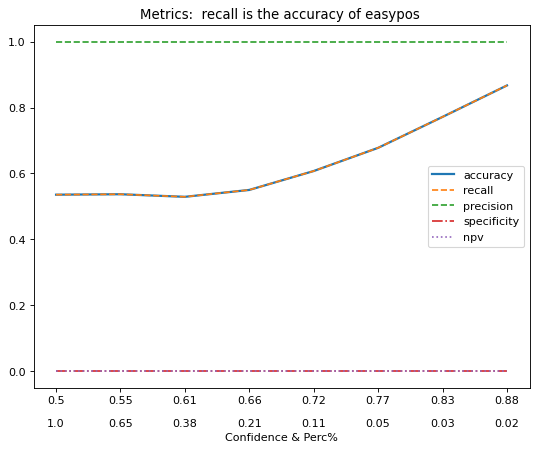

In [24]:
ep = res[(res.policy == 'easypos')]
print(ep[ep.ground_truth == ep.prediction].shape[0]/ep.shape[0])

obtain_plot(ep, n_original_df = res.shape[0], title = f'Metrics:  recall is the accuracy of easypos ', n_conf = n_conf)

0.5969950258961079


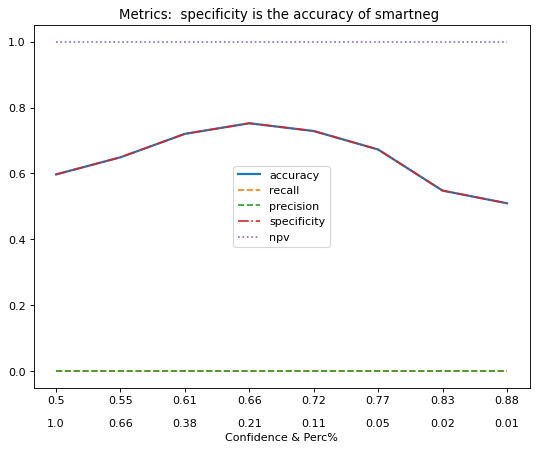

In [25]:
sn = res[(res.policy == 'smartneg')]
print(sn[sn.ground_truth == sn.prediction].shape[0]/sn.shape[0])

obtain_plot(sn, n_original_df = res.shape[0], title = f'Metrics:  specificity is the accuracy of smartneg ', n_conf = n_conf)

0.7848605577689243


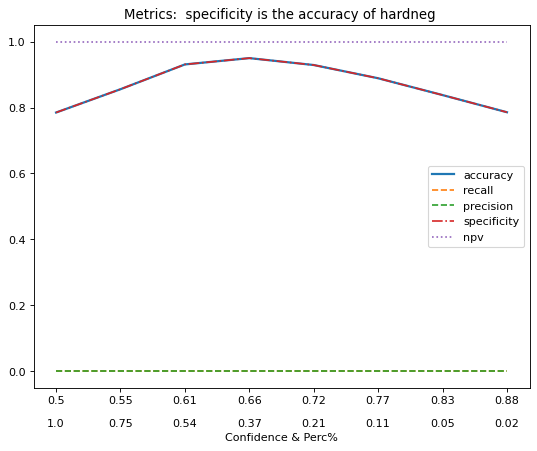

In [26]:
hn = res[(res.policy == 'hardneg')]
print(hn[hn.ground_truth == hn.prediction].shape[0]/hn.shape[0])

obtain_plot(hn, n_original_df = res.shape[0], title = f'Metrics:  specificity is the accuracy of hardneg ', n_conf = n_conf)

0.8284714119019837


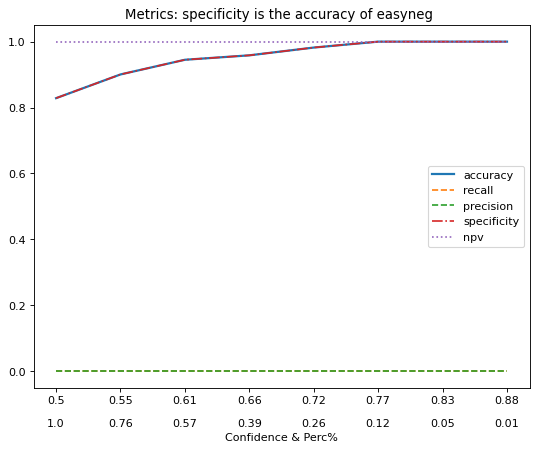

In [27]:
easy = res[(res.policy == 'easyneg')]
print(easy[easy.ground_truth == easy.prediction].shape[0]/easy.shape[0])

obtain_plot(easy, n_original_df = res.shape[0], title = f'Metrics: specificity is the accuracy of easyneg ', n_conf = n_conf)

0.6702236024844721


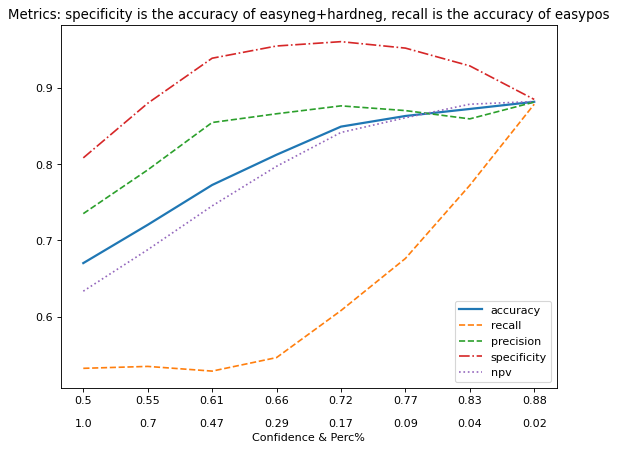

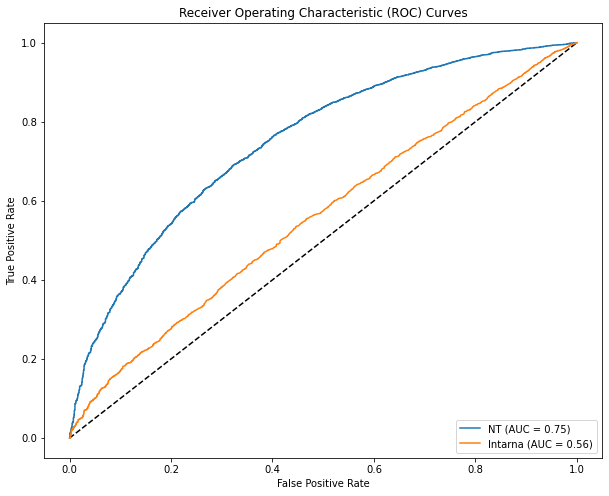

In [28]:
ephnen = res[(res.policy == 'easyneg')|(res.policy == 'easypos')|(res.policy == 'hardneg')]

ephnen_sampled = balance_df(ephnen)

print(ephnen_sampled[ephnen_sampled.ground_truth == ephnen_sampled.prediction].shape[0]/ephnen_sampled.shape[0])
obtain_plot(ephnen_sampled, n_original_df = res.shape[0], title = f'Metrics: specificity is the accuracy of easyneg+hardneg, recall is the accuracy of easypos', n_conf = n_conf)
plot_roc_curves([{'prob': ephnen_sampled.probability, 'model_name': 'NT'},
                 {'prob': abs(ephnen_sampled.E_norm), 'model_name': 'Intarna'}
                ], ephnen_sampled.ground_truth)

0.6728819875776397


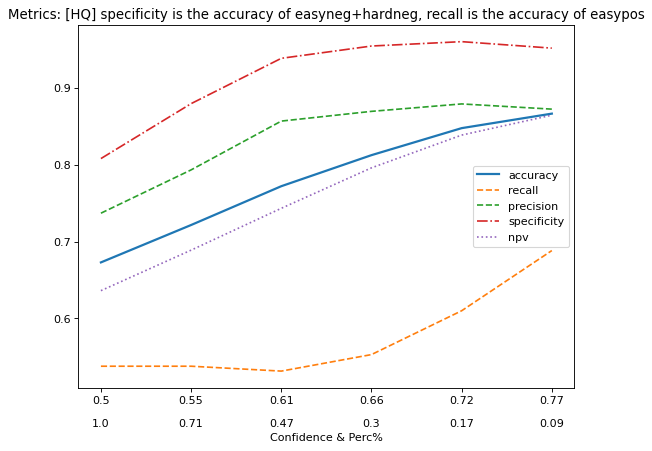

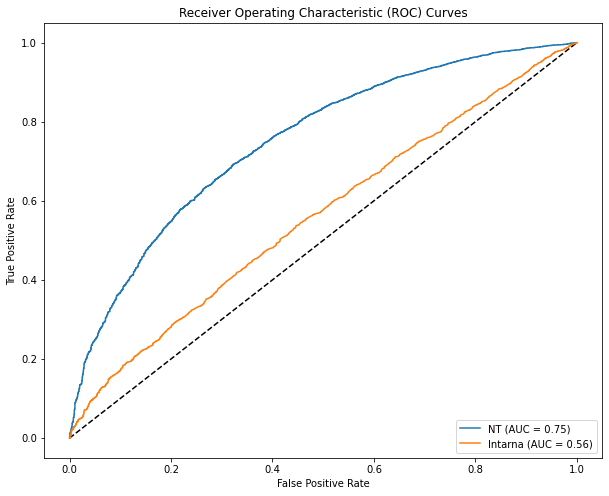

In [29]:
poshq = set(easypos_smartneg_HQ[easypos_smartneg_HQ.ground_truth == 1].id_sample)
ephnen = res[(res.policy == 'easyneg')|(res.id_sample.isin(poshq))|(res.policy == 'hardneg')]

ephnen_sampled = balance_df(ephnen)

print(ephnen_sampled[ephnen_sampled.ground_truth == ephnen_sampled.prediction].shape[0]/ephnen_sampled.shape[0])
obtain_plot(ephnen_sampled, n_original_df = res.shape[0], title = f'Metrics: [HQ] specificity is the accuracy of easyneg+hardneg, recall is the accuracy of easypos', n_conf = n_conf, excluding_treshold = 0.05)
plot_roc_curves([{'prob': ephnen_sampled.probability, 'model_name': 'NT'},
                 {'prob': abs(ephnen_sampled.E_norm), 'model_name': 'Intarna'}
                ], ephnen_sampled.ground_truth)

In [30]:
df_nt = pd.read_csv(os.path.join(metadata_dir, f'{suffix}', f'df_nt.csv'))
regex = df_nt[df_nt.couples.isin(gene_pairs_train)].couples_id.str.extractall('(.*)_(.*)').reset_index()
df_train = regex
df_train['g1'] = regex[0]
df_train['g2'] = regex[1]
df_train_genes = set(df_train['g1']).union(set(df_train['g2']))

not_in_train = res[~(res.gene1_original.isin(df_train_genes) | res.gene2_original.isin(df_train_genes))]

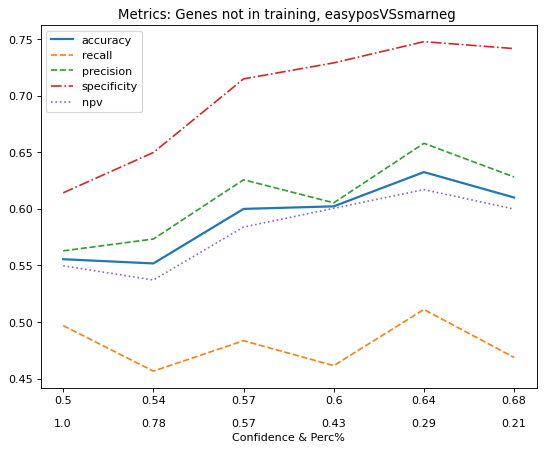

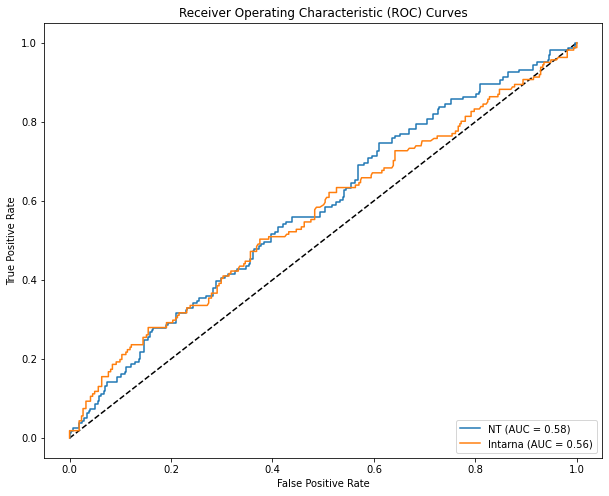

In [31]:
not_in_train_epsn = not_in_train[(not_in_train.policy == 'easypos')|(not_in_train.policy == 'smartneg')]

not_in_train_epsn_balanced = balance_df(not_in_train_epsn)
obtain_plot(not_in_train_epsn_balanced, n_original_df = res.shape[0], title = f'Metrics: Genes not in training, easyposVSsmarneg ', n_conf = 15, excluding_treshold = 0.2)

plot_roc_curves([{'prob': not_in_train_epsn_balanced.probability, 'model_name': 'NT'},
                 {'prob': abs(not_in_train_epsn_balanced.E_norm), 'model_name': 'Intarna'}
                ], not_in_train_epsn_balanced.ground_truth)

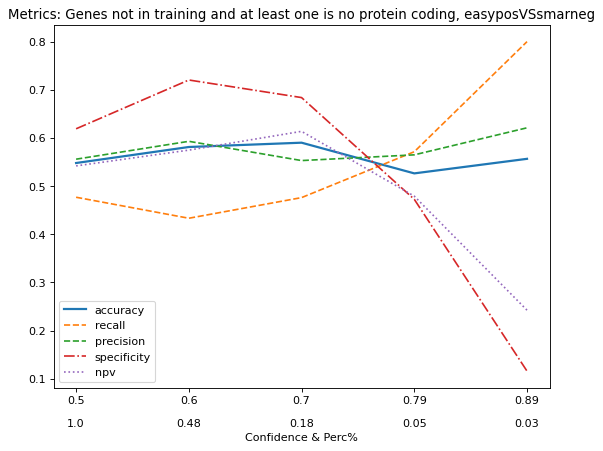

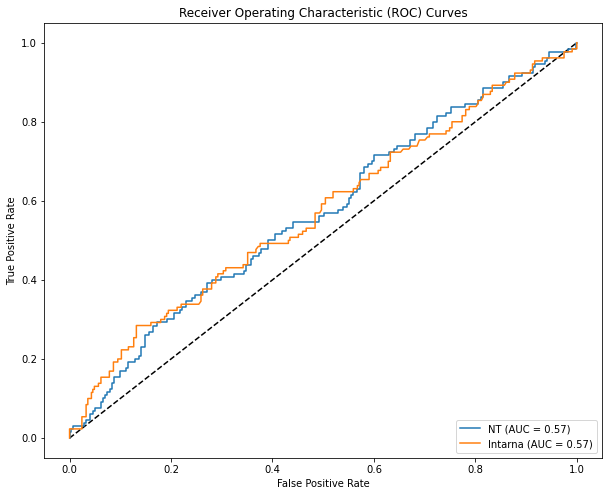

In [32]:
no_pc_no_train = not_in_train_epsn[(not_in_train_epsn['gene1_pc'] == False)|(not_in_train_epsn['gene2_pc'] == False)]

no_pc_no_train = balance_df(no_pc_no_train)

obtain_plot(no_pc_no_train, n_original_df = res.shape[0], title = f'Metrics: Genes not in training and at least one is no protein coding, easyposVSsmarneg', n_conf = 6)

plot_roc_curves([{'prob': no_pc_no_train.probability, 'model_name': 'NT'},
                 {'prob': abs(no_pc_no_train.E_norm), 'model_name': 'Intarna'}
                ], no_pc_no_train.ground_truth)

### Compare with Intarna

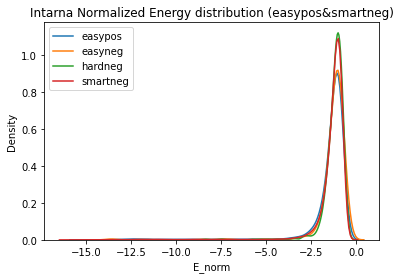

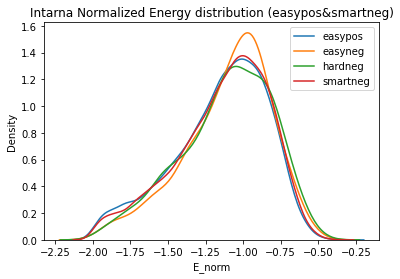

In [33]:
sns.kdeplot(res[res.policy == 'easypos'].E_norm, label = 'easypos')
sns.kdeplot(res[res.policy == 'easyneg'].E_norm, label = 'easyneg')
sns.kdeplot(res[res.policy == 'hardneg'].E_norm, label = 'hardneg')
sns.kdeplot(res[res.policy == 'smartneg'].E_norm, label = 'smartneg')
plt.title(f'Intarna Normalized Energy distribution (easypos&smartneg)')
plt.legend()
plt.show()

treshold_plot = -2
sns.kdeplot(res[(res.policy == 'easypos')&(res.E_norm>treshold_plot)].E_norm, label = 'easypos')
sns.kdeplot(res[(res.policy == 'easyneg')&(res.E_norm>treshold_plot)].E_norm, label = 'easyneg')
sns.kdeplot(res[(res.policy == 'hardneg')&(res.E_norm>treshold_plot)].E_norm, label = 'hardneg')
sns.kdeplot(res[(res.policy == 'smartneg')&(res.E_norm>treshold_plot)].E_norm, label = 'smartneg')
plt.title(f'Intarna Normalized Energy distribution (easypos&smartneg)')
plt.legend()
plt.show()

In [34]:
def plot_ROC_based_on_confidence(df, how = 'intarna', treshold = 0.05):
    if how == 'intarna':
        subset = df[
            (df.E_norm <= df.E_norm.quantile(treshold))|
            (df.E_norm >= df.E_norm.quantile(1-treshold))
        ]
    elif how == 'nt':
        subset = df[
            (df.probability <= treshold)|
            (df.probability >= (1-treshold))
        ]
    else:
        raise NotImplementedError
    print('perc of the total data: ', np.round(subset.shape[0]/df.shape[0], 3)*100, '%')
    plot_roc_curves([{'prob': subset.probability, 'model_name': 'NT'},
                 {'prob': abs(subset.E_norm), 'model_name': 'Intarna'}
                ], subset.ground_truth)

perc of the total data:  20.0 %


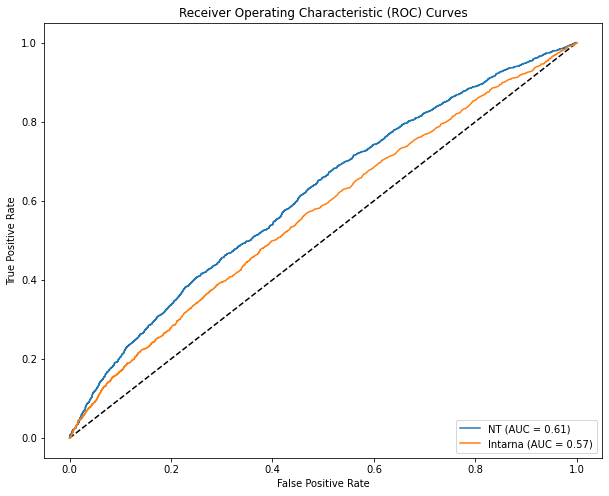

In [35]:
plot_ROC_based_on_confidence(easypos_smartneg, treshold = 0.1)

perc of the total data:  0.8999999999999999 %


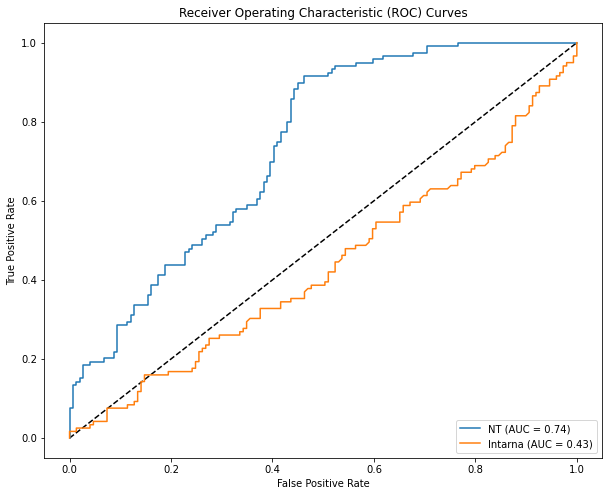

In [36]:
plot_ROC_based_on_confidence(easypos_smartneg, how = 'nt', treshold = 0.1)

Text(0.5, 0, 'Confidence & Perc%')

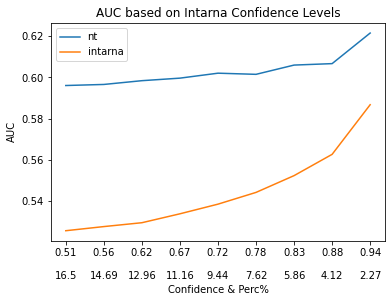

In [37]:
confidence_level, auc_nt, auc_intarna = collect_results_based_on_confidence_level( easypos_smartneg, how = 'intarna', n_values = 10)

plt.plot(confidence_level, auc_nt, label = 'nt')
plt.plot(confidence_level, auc_intarna, label = 'intarna')
plt.title('AUC based on Intarna Confidence Levels')
plt.legend()

plt.ylabel('AUC')
plt.xlabel(f"Confidence & Perc%")

Text(0.5, 0, 'Confidence & Perc%')

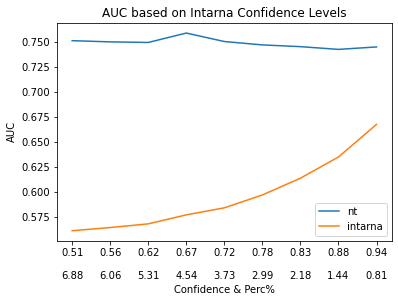

In [38]:
confidence_level, auc_nt, auc_intarna = collect_results_based_on_confidence_level( res[(res.policy == 'easyneg')|(res.policy == 'easypos')|(res.policy == 'hardneg')], how = 'intarna', n_values = 10)

plt.plot(confidence_level, auc_nt, label = 'nt')
plt.plot(confidence_level, auc_intarna, label = 'intarna')
plt.title('AUC based on Intarna Confidence Levels')
plt.legend()

plt.ylabel('AUC')
plt.xlabel(f"Confidence & Perc%")

Text(0.5, 0, 'Confidence & Perc%')

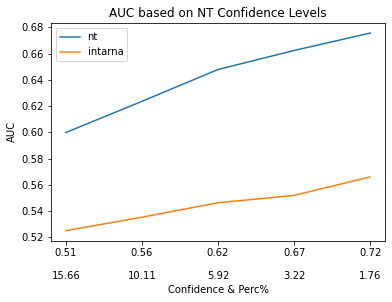

In [39]:
confidence_level, auc_nt, auc_intarna = collect_results_based_on_confidence_level(easypos_smartneg, how = 'nt', n_values = 10)

plt.plot(confidence_level, auc_nt, label = 'nt')
plt.plot(confidence_level, auc_intarna, label = 'intarna')
plt.title('AUC based on NT Confidence Levels')
plt.legend()

plt.ylabel('AUC')
plt.xlabel(f"Confidence & Perc%")

Text(0.5, 0, 'Confidence & Perc%')

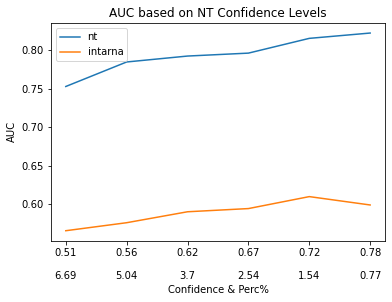

In [40]:
confidence_level, auc_nt, auc_intarna = collect_results_based_on_confidence_level(res[(res.policy == 'easyneg')|(res.policy == 'easypos')|(res.policy == 'hardneg')], how = 'nt', n_values = 10)

plt.plot(confidence_level, auc_nt, label = 'nt')
plt.plot(confidence_level, auc_intarna, label = 'intarna')
plt.title('AUC based on NT Confidence Levels')
plt.legend()

plt.ylabel('AUC')
plt.xlabel(f"Confidence & Perc%")

# XAI

In [39]:
df_genes_nt = pd.read_csv(os.path.join(metadata_dir, f'{suffix}', f'df_genes_nt.csv'))

DEVICE = 'cuda'

args_path = os.path.join(checkpoint_dir, 'args.pkl')

# Load the args namespace from the file
with open(args_path, 'rb') as f:
    args_dict = pickle.load(f)

# Convert the dictionary to an argparse.Namespace object
args = argparse.Namespace(**args_dict)
args.resume = os.path.join(checkpoint_dir, 'best_model.pth') # best_model

device = torch.device(DEVICE)
model = build_model(args)

checkpoint = torch.load(args.resume, map_location='cpu')
model.load_state_dict(checkpoint['model'])

model.to(device)
model.eval()

/data01/giorgio/ENTER/envs/dnabert/lib/python3.9/site-packages/torch/nn/init.py:388: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


BinaryClassifierNT(
  (nt_projection_module): NTProjectionModule(
    (conv1d): Conv1d(2560, 0, kernel_size=(1,), stride=(1,))
    (bn): BatchNorm1d(2560, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (top_classifier): MLP(
    (input_layer): Sequential(
      (0): LayerNorm((5120,), eps=1e-05, elementwise_affine=True)
      (1): Linear(in_features=5120, out_features=512, bias=True)
    )
    (hidden_layers): ModuleList()
    (output_layer): Linear(in_features=512, out_features=800, bias=True)
    (activation_functions): ModuleList(
      (0): Tanh()
    )
    (dropout_layers): ModuleList(
      (0): Dropout(p=0.01, inplace=False)
    )
  )
  (small_cnn): SmallCNN(
    (conv1): Conv2d(800, 400, kernel_size=(2, 2), stride=(1, 1))
    (conv2): Conv2d(400, 600, kernel_size=(1, 1), stride=(1, 1))
    (relu): ReLU()
    (maxpool2d): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
    (tanh): Tanh()
    (global_avg_pool): AdaptiveAvgPool2d(o

In [41]:
xai = pd.read_csv(os.path.join(checkpoint_dir, f'gradcam_results_{HOW}500.csv'))

In [42]:
xai = xai.merge(res.filter([
    'couples', 'gene1_pc', 'gene2_pc', 'original_length1', 'original_length2', 'id_sample', 'g1', 'g2', 'gene1_original', 'gene2_original'
], axis = 1), left_on = 'id', right_on = 'id_sample')

In [43]:
gradcam_results = xai[xai.probability>0.5]

iou_value: 0.0059
iou_value_tr: 0.0048
iou_value_rand: 0.0028


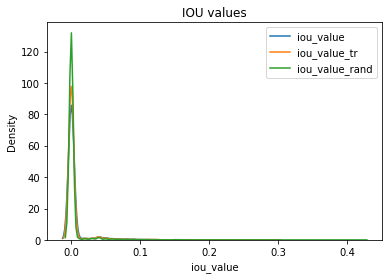

intensity: 0.2704
intensity_tr: 0.0997
intensity_rand: 0.5


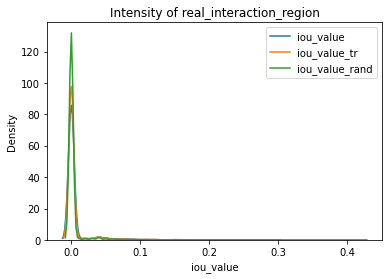

euclidean: 0.4658
euclidean_rand: 0.5294
euclidean_bbox_tr: 0.51


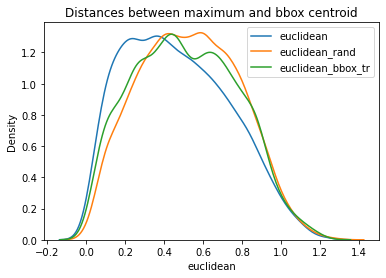

cos_sim: 0.05
cos_sim_tr: 0.03
cos_sim_rand: 0.05


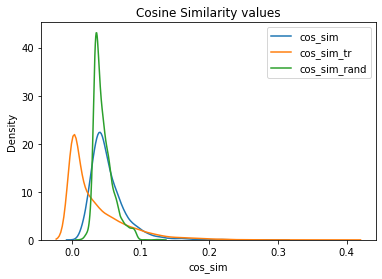

In [44]:
iou_columns = ['iou_value', 'iou_value_tr', 'iou_value_rand']
for c in iou_columns:
    print(f'{c}: {str(np.round(gradcam_results[c].mean(), 4))}')

for c in iou_columns:
    sns.kdeplot(gradcam_results[c], label = c)
plt.title(f'IOU values')
plt.legend()
plt.show()

intensity_columns = ['intensity', 'intensity_tr', 'intensity_rand']
for c in intensity_columns:
    print(f'{c}: {str(np.round(gradcam_results[c].mean(), 4))}')

for c in iou_columns:
    sns.kdeplot(gradcam_results[c], label = c)
    
plt.title(f'Intensity of real_interaction_region')
plt.legend()
plt.show()

euclidean_columns = ['euclidean', 'euclidean_rand', 'euclidean_bbox_tr']
for c in euclidean_columns:
    print(f'{c}: {str(np.round(gradcam_results[c].mean(), 4))}')

for c in euclidean_columns:
    sns.kdeplot(gradcam_results[c], label = c)
plt.title(f'Distances between maximum and bbox centroid')
plt.legend()
plt.show()

cosine_sim_columns = ['cos_sim', 'cos_sim_tr', 'cos_sim_rand']
for c in cosine_sim_columns:
    print(f'{c}: {str(np.round(gradcam_results[c].mean(), 2))}')

for c in cosine_sim_columns:
    sns.kdeplot(gradcam_results[c], label = c)
plt.title(f'Cosine Similarity values')
plt.legend()
plt.show()

#### Subset XAI results

In [45]:
df_nt = pd.read_csv(os.path.join(metadata_dir, f'{suffix}', f'df_nt.csv'))
regex = df_nt[df_nt.couples.isin(gene_pairs_train)].couples_id.str.extractall('(.*)_(.*)').reset_index()
df_train = regex
df_train['g1'] = regex[0]
df_train['g2'] = regex[1]
df_train_genes = set(df_train['g1']).union(set(df_train['g2']))

euclidean: 0.4548
euclidean_rand: 0.6471


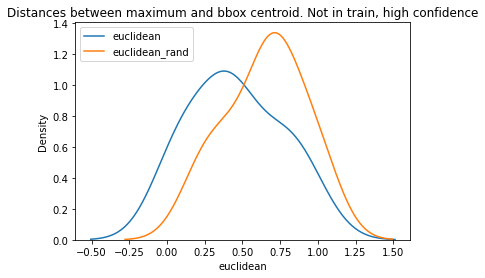

In [46]:
gradcam_results = xai[~(xai.gene1_original.isin(df_train_genes) | xai.gene2_original.isin(df_train_genes))]
gradcam_results = gradcam_results[(gradcam_results.probability>0.65)&(gradcam_results.probability<0.8)]

euclidean_columns = ['euclidean', 'euclidean_rand']
for c in euclidean_columns:
    print(f'{c}: {str(np.round(gradcam_results[c].mean(), 4))}')

for c in euclidean_columns:
    sns.kdeplot(gradcam_results[c], label = c)
plt.title(f'Distances between maximum and bbox centroid. Not in train, high confidence')
plt.legend()
plt.show()

In [47]:
def plot_query_results(query):
    for _, row in query.iterrows():
        x1_emb, x2_emb, y1_emb, y2_emb = int(np.round(row.x1/6)), int(np.round(row.x2/6)), int(np.round(row.y1/6)), int(np.round(row.y2/6))
        
        embedding1_path = os.path.join(embedding_dir, '32', row.gene1+'.npy')
        embedding2_path = os.path.join(embedding_dir, '32', row.gene2+'.npy')

        embedding1 = np.load(embedding1_path)[x1_emb:x2_emb :]
        embedding2 = np.load(embedding2_path)[y1_emb:y2_emb, :]

        rna1, rna2 = torch.as_tensor(embedding1).unsqueeze(0), torch.as_tensor(embedding2).unsqueeze(0)
        rna1, rna2 = torch.transpose(rna1, 1, 2), torch.transpose(rna2, 1, 2)

        rna1, rna2 = rna1.to(device), rna2.to(device)
        
        outputs = model(rna1, rna2)

        outputs[:, 1].backward()
        #print('prob:', outputs.softmax(-1)[:, 1])
        #print('degree:', row.abs_sum_diff)
        x1 = int(row.seed_x1-row.x1)
        x2 = int(row.seed_x2-row.x1)
        y1 = int(row.seed_y1-row.y1)
        y2 = int(row.seed_y2-row.y1)
        width = row.len1
        height = row.len2
        

        expl_matrix = gradcam(model, rna1, rna2, counterfactual = False, cnn_layer = 2)
        
        expl_matrix_reshaped = interpolate_expl_matrix(expl_matrix, height=height, width=width)
        
        # print(x1, x2, y1, y2)
        # print(expl_matrix_reshaped.shape)

        scaling_factor = 70

        plot_matrix(expl_matrix_reshaped, 
        [[y1, x1, y2-y1, x2-x1]], #crop_bbox =[x1hat, y1hat, what, hhat], 
        cmap ='viridis', 
        scaling_factor = scaling_factor)
        plt.show()

euclidean: 0.4479
euclidean_rand: 0.5459


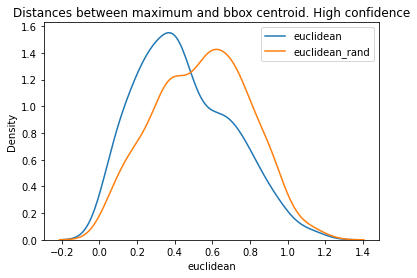

In [48]:
gradcam_results = xai[(xai.probability>0.75)]

euclidean_columns = ['euclidean', 'euclidean_rand']
for c in euclidean_columns:
    print(f'{c}: {str(np.round(gradcam_results[c].mean(), 4))}')

for c in euclidean_columns:
    sns.kdeplot(gradcam_results[c], label = c)
plt.title(f'Distances between maximum and bbox centroid. High confidence')
plt.legend()
plt.show()

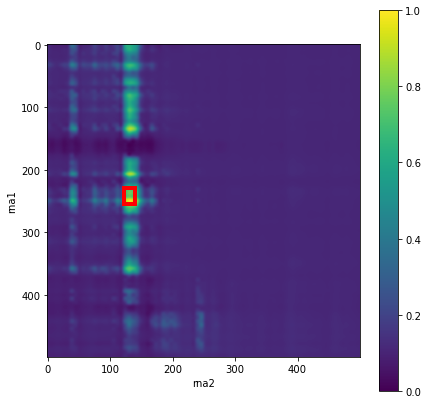

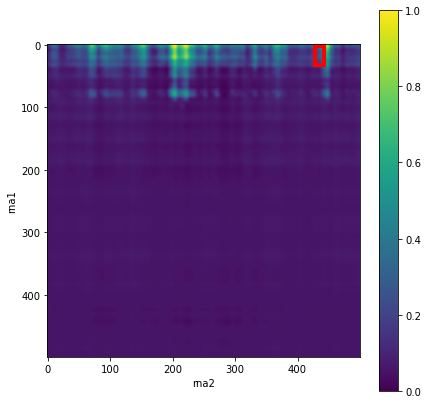

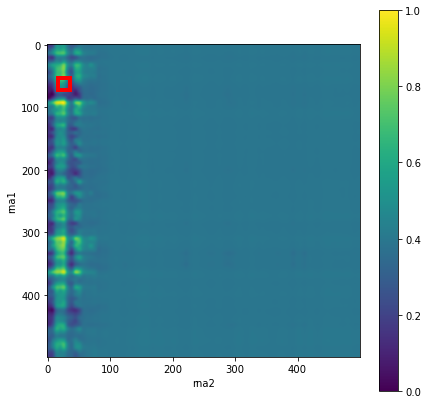

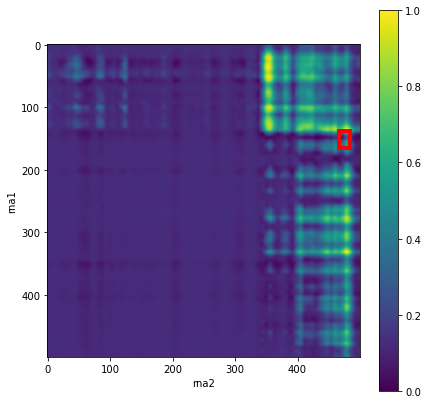

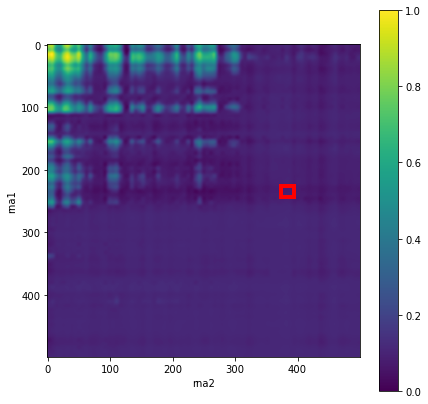

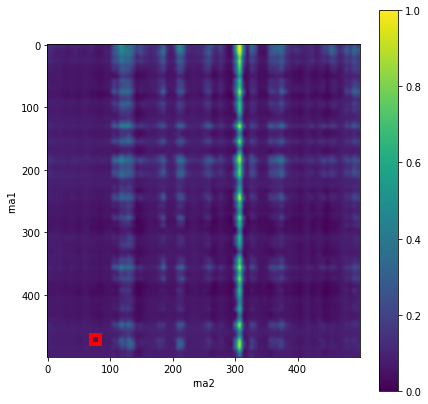

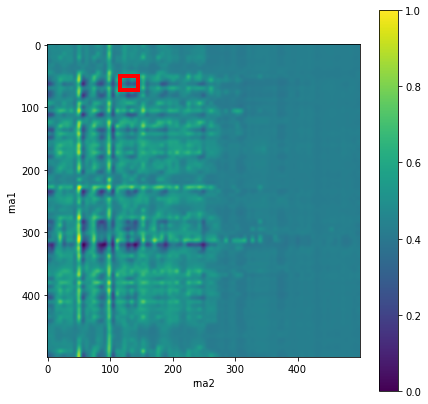

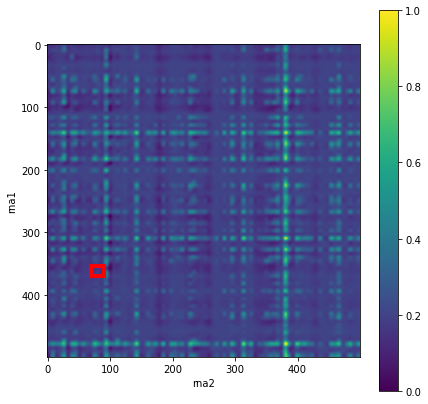

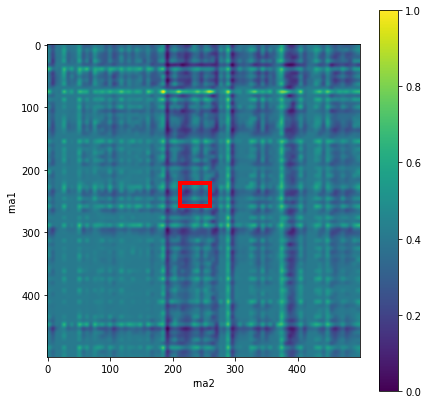

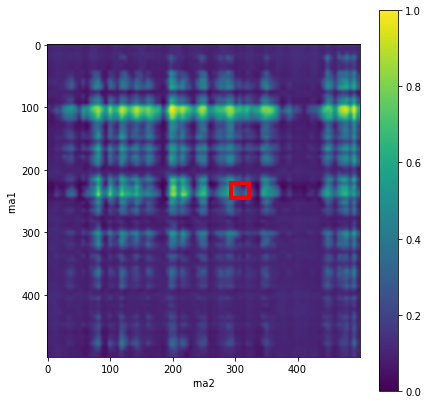

In [49]:
query = test500[test500.couples.isin(list(gradcam_results.id))]
plot_query_results(query.sample(10))

At least one gene is not in training

euclidean: 0.3605
euclidean_rand: 0.6758


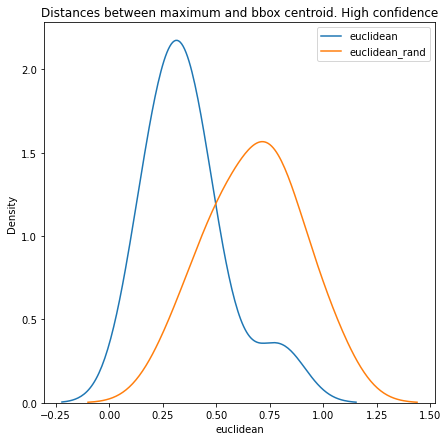

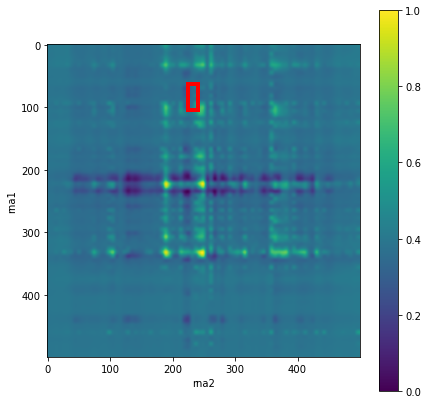

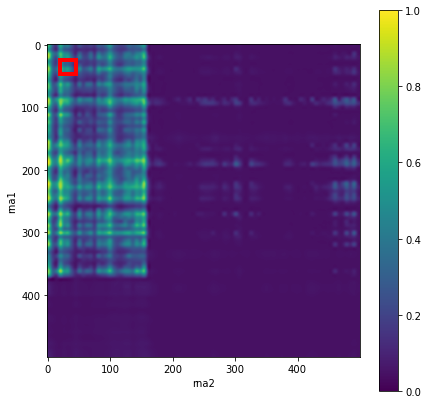

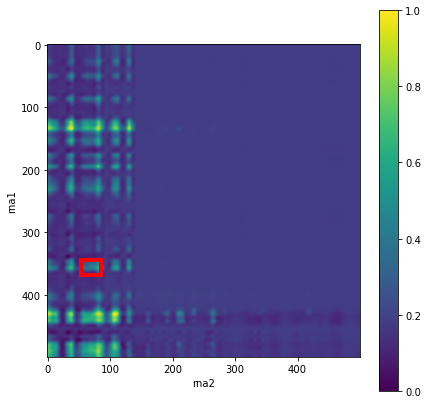

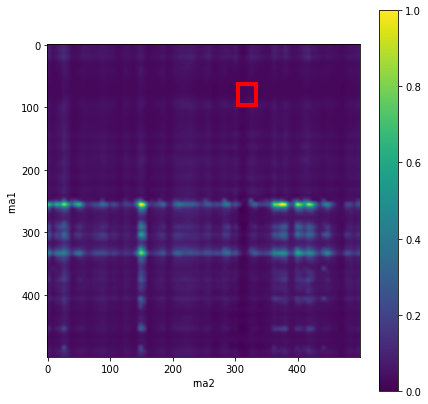

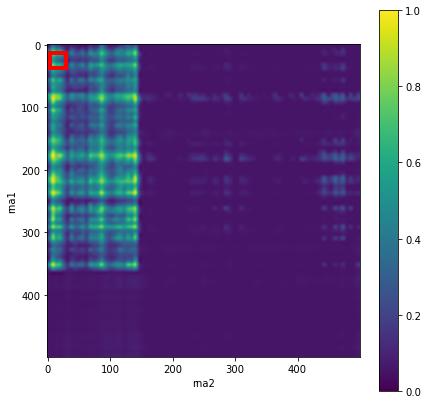

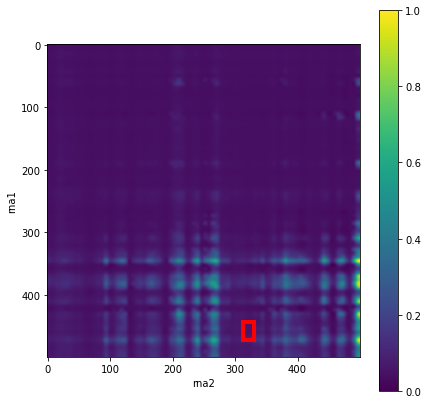

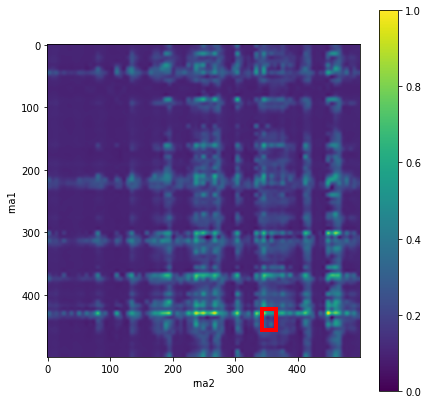

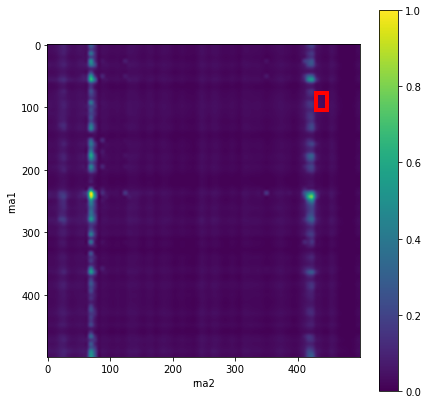

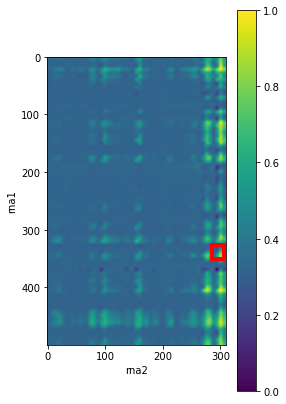

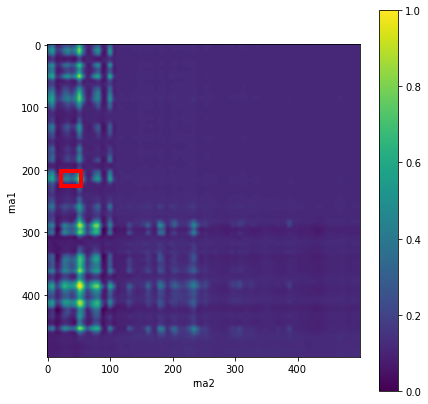

In [50]:
n_best = 10

gradcam_results = xai[~(xai.gene1_original.isin(df_train_genes) | xai.gene2_original.isin(df_train_genes))]

gradcam_results = gradcam_results.sort_values('probability').tail(n_best)

euclidean_columns = ['euclidean', 'euclidean_rand']
for c in euclidean_columns:
    print(f'{c}: {str(np.round(gradcam_results[c].mean(), 4))}')

for c in euclidean_columns:
    sns.kdeplot(gradcam_results[c], label = c)
plt.title(f'Distances between maximum and bbox centroid. High confidence')
plt.legend()
plt.show()

query = test500[test500.couples.isin(list(gradcam_results.id))]
plot_query_results(query)